# YOLOv8 Object Detection Example

## 1. Introduction

This notebook demonstrates a complete workflow for object detection using YOLOv8, a state-of-the-art, real-time object detection model. We will cover the essential steps from setting up the environment to performing inference with a fine-tuned model.

**Dataset:** We will use the **COCO8 dataset**, a small subset of the COCO (Common Objects in Context) dataset, provided by Ultralytics. It contains 8 images (4 for training, 4 for validation) and includes the standard 80 COCO object classes. This dataset is ideal for quick tests and demonstrations.

**Steps Covered:**
1.  **Setup:** Installing necessary libraries (`ultralytics` for YOLOv8, `PyTorch`, `OpenCV`).
2.  **Data Preparation:** Downloading the dataset, understanding its structure, and preparing the `data.yaml` configuration file required for YOLOv8 training.
3.  **Model Training (Fine-tuning):** Loading a pre-trained YOLOv8 model and fine-tuning it on our custom dataset.
4.  **Inference and Visualization:** Using the fine-tuned model to detect objects in new images and visualizing the results.

## 2. Setup: Install Libraries

In [12]:
# Install Ultralytics for YOLOv8
# This package contains the YOLOv8 model implementation and utilities.
!pip install ultralytics

# Install PyTorch and torchvision
# YOLOv8 is built on PyTorch. Torchvision provides useful image transformation tools.
!pip install torch torchvision

# Install OpenCV for image processing
# OpenCV is used for image loading, manipulation, and displaying results.
!pip install opencv-python-headless

The code cell above installs the essential packages: `ultralytics` for YOLOv8, `torch` and `torchvision` as its deep learning framework, and `opencv-python-headless` for image processing tasks. Using `opencv-python-headless` is often preferred in server or container environments where GUI features are not needed.

## 3. Download and Prepare Dataset

For this notebook, we use the **COCO8 dataset**, a small subset of the COCO (Common Objects in Context) dataset provided by Ultralytics. It's designed for quick testing and includes 8 images (4 for training, 4 for validation) across the 80 standard COCO classes. This allows for a rapid demonstration of the training and inference pipeline.

In [13]:
# Download the COCO8 dataset
# The '-q' flag for wget makes it operate quietly.
# '-O coco8.zip' specifies the output filename.
!wget -q https://github.com/ultralytics/assets/releases/download/v0.0.0/coco8.zip -O coco8.zip

# Unzip the dataset
# The '-q' flag makes unzip operate quietly.
# The '-d ./datasets/' extracts files into the './datasets/' directory, creating 'coco8' inside it.
!unzip -q coco8.zip -d ./datasets/

# Remove the zip file after extraction to save space
!rm coco8.zip

# List the contents of the dataset directory to understand its structure
!ls ./datasets/coco8

images	labels	LICENSE  README.md


The COCO8 dataset has been downloaded and unzipped into the `./datasets/coco8` directory.
The structure of COCO8 typically is:
- `images/train/`: Directory with training images.
- `images/val/`: Directory with validation images.
- `labels/train/`: Directory with corresponding label files for training images.
- `labels/val/`: Directory with corresponding label files for validation images.
- Each image file (e.g., `image.jpg`) has a corresponding text file (`image.txt`) in the respective `labels` subdirectory, where each line in the text file defines a bounding box (`class_id x_center y_center width height`).
- A `coco8.yaml` file is often included, which we will essentially replicate as `custom_data.yaml` but with absolute paths for robustness in Colab.

### Purpose of `data.yaml`

The `data.yaml` file is crucial for YOLOv8 as it provides the model with essential information about the dataset:

- `path`: An absolute path to the root directory of the dataset (e.g., `/content/datasets/coco8`).
- `train`: Path to the directory containing training images, relative to `path` (e.g., `images/train`).
- `val`: Path to the directory containing validation images, relative to `path` (e.g., `images/val`).
- `test` (optional): Path to the directory containing test images, relative to `path`.
- `names`: A dictionary or list of class names, where the index corresponds to the class ID. COCO8 uses the 80 standard COCO classes.

We will create our own `custom_data.yaml` file in the Colab root directory (`/content/`) to explicitly define these parameters, ensuring clarity and correct pathing for the YOLOv8 training process.

In [14]:
import yaml
import os

# Define the absolute path to the COCO8 dataset in Colab environment
dataset_path = '/content/datasets/coco8'

# Define the COCO class names (80 classes)
coco_names = {
    0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat',
    9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat',
    16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack',
    25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball',
    33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket',
    39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple',
    48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake',
    56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop',
    64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink',
    72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier',
    79: 'toothbrush'
}

# Create the dictionary for our custom_data.yaml content
custom_data_yaml_content = {
    'path': dataset_path,
    'train': 'images/train',  # Relative to 'path'
    'val': 'images/val',      # Relative to 'path'
    # COCO8 typically doesn't have a separate 'test' set in its default zip,
    # so we'll omit it or one could point 'test' to 'images/val' if needed.
    'names': coco_names
}

# Define the name for our custom YAML file (to be created in /content/)
output_yaml_path = 'custom_data.yaml'

# Write the custom_data.yaml file
with open(output_yaml_path, 'w') as f:
    yaml.dump(custom_data_yaml_content, f, sort_keys=False, default_flow_style=None)

print(f"--- Content of created {output_yaml_path} ---")
with open(output_yaml_path, 'r') as f:
    print(f.read())

# Verify that the dataset path and image directories exist
print(f"\nChecking dataset paths:")
print(f"Dataset root exists: {os.path.exists(dataset_path)}")
print(f"Train images directory exists: {os.path.exists(os.path.join(dataset_path, custom_data_yaml_content['train']))}")
print(f"Validation images directory exists: {os.path.exists(os.path.join(dataset_path, custom_data_yaml_content['val']))}")

--- Content of created custom_data.yaml ---
path: /content/datasets/coco8
train: images/train
val: images/val
names: {0: person, 1: bicycle, 2: car, 3: motorcycle, 4: airplane, 5: bus, 6: train,
  7: truck, 8: boat, 9: traffic light, 10: fire hydrant, 11: stop sign, 12: parking
    meter, 13: bench, 14: bird, 15: cat, 16: dog, 17: horse, 18: sheep, 19: cow, 20: elephant,
  21: bear, 22: zebra, 23: giraffe, 24: backpack, 25: umbrella, 26: handbag, 27: tie,
  28: suitcase, 29: frisbee, 30: skis, 31: snowboard, 32: sports ball, 33: kite, 34: baseball
    bat, 35: baseball glove, 36: skateboard, 37: surfboard, 38: tennis racket, 39: bottle,
  40: wine glass, 41: cup, 42: fork, 43: knife, 44: spoon, 45: bowl, 46: banana, 47: apple,
  48: sandwich, 49: orange, 50: broccoli, 51: carrot, 52: hot dog, 53: pizza, 54: donut,
  55: cake, 56: chair, 57: couch, 58: potted plant, 59: bed, 60: dining table, 61: toilet,
  62: tv, 63: laptop, 64: mouse, 65: remote, 66: keyboard, 67: cell phone, 68: micr

The code cell above performs the following actions:
1.  Defines the absolute path to where the COCO8 dataset is stored (`/content/datasets/coco8`).
2.  Defines a dictionary `coco_names` containing all 80 standard COCO class names.
3.  Constructs the content for `custom_data.yaml`, specifying the dataset `path`, relative paths for `train` and `val` image directories, and the `names` dictionary.
4.  Writes this configuration to `custom_data.yaml` in the Colab root directory (`/content/custom_data.yaml`). This file will be used by YOLOv8 for training.
5.  Prints the content of the created YAML file and verifies the existence of the specified dataset paths.

## 4. Model Training (Fine-tuning)

In [15]:
from ultralytics import YOLO
import os # os is already imported, but good to have it here if this cell is run independently

# Load a pre-trained YOLOv8 model.
# 'yolov8n.pt' is the nano version, which is small and fast, suitable for quick demonstrations.
# Other versions like 'yolov8s.pt', 'yolov8m.pt', 'yolov8l.pt', 'yolov8x.pt' offer higher accuracy at the cost of size and speed.
# Using a '.pt' file loads pre-trained weights. Using a '.yaml' file (e.g., 'yolov8n.yaml') would build the model from scratch based on its architecture definition.
model = YOLO('yolov8n.pt')

# Display model information (optional, but useful for verification)
# This shows the model architecture, number of layers, parameters, and GFLOPs.
model.info()

YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(129, 3157200, 0, 8.8575488)

We are loading `yolov8n.pt`, which is a YOLOv8 nano model pre-trained on the COCO dataset. By using a pre-trained model, we leverage **transfer learning**.

**Benefits of Transfer Learning:**
- **Faster Training:** The model has already learned general visual features (edges, textures, basic shapes) from a large dataset. This allows it to learn the specifics of our new, smaller dataset much faster.
- **Less Data Required:** Fine-tuning often achieves good results with less data than training a model from scratch, as the foundational feature extraction capabilities are already present.
- **Potentially Better Performance:** Pre-trained models provide a strong starting point, which can lead to better overall performance, especially when the custom dataset is small or similar in nature to the pre-training dataset.

In [16]:
# Define the path to the custom_data.yaml file created in the previous step.
# This file is located in the root directory of our notebook environment.
data_yaml_path = 'custom_data.yaml'

# Train (fine-tune) the model on our custom dataset.
results = model.train(
    data=data_yaml_path,  # Path to our custom_data.yaml file.
    epochs=25,            # Number of training epochs. Keep low for a quick demo (e.g., 25-50). For production, this would be higher (e.g., 100-300).
    imgsz=640,            # Input image size. Images will be resized to 640x640 pixels.
    batch=8,              # Batch size. Adjust based on available GPU memory. Common values are 8, 16, 32.
    name='yolov8n_coco8_finetuned', # Name for the training run. Results will be saved in 'runs/detect/yolov8n_coco8_finetuned'.
    patience=5            # Early stopping patience. Training will stop if no improvement in validation metrics is observed for 5 consecutive epochs.
)

Ultralytics 8.3.141 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=custom_data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_coco8_finetuned, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pretrained=

100%|██████████| 755k/755k [00:00<00:00, 19.3MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

Model summary: 129 layers, 3,157,200 parameters, 3,157,184 gradients, 8.9 GFLOPs

Transferred 355/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 916.4±225.1 MB/s, size: 50.0 KB)


train: Scanning /content/datasets/coco8/labels/train... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 71.42it/s]

train: New cache created: /content/datasets/coco8/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1290.9±282.9 MB/s, size: 54.0 KB)


val: Scanning /content/datasets/coco8/labels/val... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 1055.90it/s]

val: New cache created: /content/datasets/coco8/labels/val.cache


Plotting labels to runs/detect/yolov8n_coco8_finetuned/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/yolov8n_coco8_finetuned
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25         0G       1.18      2.402      1.346         27        640: 100%|██████████| 1/1 [00:06<00:00,  6.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

                   all          4         17      0.621      0.863      0.888      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25         0G     0.9377      2.812      1.333         22        640: 100%|██████████| 1/1 [00:04<00:00,  4.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all          4         17      0.616      0.861      0.888      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25         0G     0.9996      3.136      1.281         26        640: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

                   all          4         17      0.597      0.833      0.872       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25         0G       1.24      2.637      1.568         28        640: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all          4         17      0.571      0.833      0.871        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25         0G      1.213      2.683      1.589         23        640: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all          4         17      0.542      0.833      0.871      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25         0G     0.9187      3.171      1.424         23        640: 100%|██████████| 1/1 [00:04<00:00,  4.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all          4         17      0.559      0.845      0.885       0.61
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



6 epochs completed in 0.010 hours.
Optimizer stripped from runs/detect/yolov8n_coco8_finetuned/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/yolov8n_coco8_finetuned/weights/best.pt, 6.5MB

Validating runs/detect/yolov8n_coco8_finetuned/weights/best.pt...
Ultralytics 8.3.141 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


                   all          4         17       0.62      0.864      0.888      0.619
                person          3         10      0.679        0.5       0.52      0.279
                   dog          1          1      0.364          1      0.995      0.597
                 horse          1          2      0.747          1      0.995      0.631
              elephant          1          2      0.561      0.683      0.828      0.319
              umbrella          1          1      0.562          1      0.995      0.995
          potted plant          1          1      0.809          1      0.995      0.895
Speed: 2.5ms preprocess, 229.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/yolov8n_coco8_finetuned


The `model.train()` function initiates the fine-tuning process.

**Key Training Parameters Explained:**
- `data`: Specifies the path to our `custom_data.yaml` file, which defines the dataset structure and class information.
- `epochs`: The number of complete passes through the entire training dataset. For this demonstration, we use 25 epochs. In real-world scenarios, this value might be significantly higher (e.g., 100, 200, or more), depending on the dataset's size and complexity, and monitored by observing validation metrics.
- `imgsz`: The input image size (height and width) for the model. All training images are resized to this dimension (e.g., 640x640 pixels).
- `batch`: The number of images processed together in one forward/backward pass during training. This should be set based on available GPU memory; larger batch sizes can sometimes lead to more stable gradients but require more memory.
- `name`: A custom name for this specific training run. YOLOv8 will create a directory with this name (e.g., `runs/detect/yolov8n_coco8_finetuned`) to store all training artifacts, including model weights, logs, and visualizations.
- `patience`: Enables early stopping. If the validation metrics do not show improvement for a specified number of epochs (here, 5), the training process will halt. This helps prevent overfitting and can save computational resources if the model has converged.

All training results, including the best model weights (`best.pt`), final model weights (`last.pt`), performance metrics (like mAP), confusion matrices, and example validation images with predictions, will be saved in a directory structured as `runs/detect/<name_argument_value>` (e.g., `runs/detect/yolov8n_coco8_finetuned`).

## 5. Inference and Visualization

In [17]:
# Import necessary libraries for inference and display
from ultralytics import YOLO # YOLO class for model loading and prediction
import cv2                  # OpenCV for image reading and color conversion
import matplotlib.pyplot as plt # Matplotlib for displaying images in the notebook
import os                   # For path manipulation and directory listing

# Path to the best trained model weights.
# This path is determined by the 'name' argument used during 'model.train()'.
# The 'best.pt' file contains the model weights that achieved the best validation performance.
fine_tuned_model_path = 'runs/detect/yolov8n_coco8_finetuned/weights/best.pt'

# Initialize model variable
inference_model = None

# Check if the trained model file exists
if not os.path.exists(fine_tuned_model_path):
    print(f"Error: Trained model weights not found at {fine_tuned_model_path}")
    print("Please ensure that:")
    print("1. The training process in the previous section completed successfully.")
    print("2. The 'name' argument in model.train() ('yolov8n_coco8_finetuned') matches the path used here.")
    print("3. The 'best.pt' file was generated in the specified directory.")
    # If the model isn't found, inference_model remains None, and subsequent cells should handle this.
else:
    # Load the fine-tuned model for inference
    inference_model = YOLO(fine_tuned_model_path)
    print(f"Successfully loaded fine-tuned model from {fine_tuned_model_path}")
    # Optionally, display model information to confirm it's the correct one
    # inference_model.info()

Successfully loaded fine-tuned model from runs/detect/yolov8n_coco8_finetuned/weights/best.pt


After training, the model weights that achieved the best performance on the validation set are saved as `best.pt`. We load this file to create our `inference_model`. The path to these weights is typically `runs/detect/<name_used_in_training>/weights/best.pt`. In our specific case, this resolves to `runs/detect/yolov8n_coco8_finetuned/weights/best.pt`.

In [18]:
# Specify the path to validation images for inference.
# We'll use some images from the validation set of our downloaded COCO8 dataset.
validation_image_dir = '/content/datasets/coco8/images/val/' # Absolute path to COCO8 validation images

# Initialize a list to store paths of sample images for inference
sample_image_files = []

# Check if the validation image directory exists
if os.path.exists(validation_image_dir):
    try:
        # Get a list of image filenames (ending with .png, .jpg, or .jpeg)
        image_filenames = [f for f in os.listdir(validation_image_dir)
                           if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        # Select the first 3 images for demonstration, if available
        sample_image_files = [os.path.join(validation_image_dir, f) for f in image_filenames[:3]]
        if not sample_image_files:
            print(f"No images found in {validation_image_dir}")
    except Exception as e:
        print(f"Error listing images from {validation_image_dir}: {e}")
else:
    print(f"Error: Validation image directory not found at '{validation_image_dir}'. Please check the path.")

# Proceed with inference only if the model loaded successfully and sample images were found
if inference_model and sample_image_files:
    print(f"Performing inference on {len(sample_image_files)} sample images...")
    # Run inference using the predict method.
    # 'source' can be a single image path, a list of image paths, or a directory.
    # 'save=True' will save the images with predictions (bounding boxes, labels, scores).
    # 'conf=0.5' sets the confidence threshold; only detections with score > 0.5 will be considered.
    results = inference_model.predict(source=sample_image_files, save=True, conf=0.5)
    print(f"Inference complete. Results are saved by default in a 'runs/detect/predict*' directory.")
    # The 'results' object itself is a list of Results objects, containing detailed detection data.
elif not inference_model:
    print("Skipping inference as the fine-tuned model was not loaded successfully.")
else:
    print("Skipping inference as no sample images were found.")

Performing inference on 3 sample images...

0: 640x640 1 person, 1 umbrella, 224.8ms
1: 640x640 1 dog, 1 horse, 1 potted plant, 224.8ms
2: 640x640 (no detections), 224.8ms
Speed: 4.8ms preprocess, 224.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
Inference complete. Results are saved by default in a 'runs/detect/predict*' directory.


The `model.predict()` (or in our case, `inference_model.predict()`) function is used to perform object detection on new images or videos.

**Key `predict()` Parameters:**
- `source`: This can be a path to a single image, a list of image paths, a path to a directory containing images, a path to a video file, or even a live camera feed ID.
- `save`: If set to `True` (default is `False`), the images (or video frames) with the drawn bounding boxes, class labels, and confidence scores will be saved. They are typically stored in a new directory like `runs/detect/predict`, `runs/detect/predict2`, and so on.
- `conf`: This is the confidence threshold. Only detections with a confidence score greater than this value will be considered valid. A common starting point is 0.25, but it can be adjusted (e.g., to 0.5 as used here) depending on the desired trade-off between recall and precision.

Showing results from the latest prediction directory: runs/detect/predict


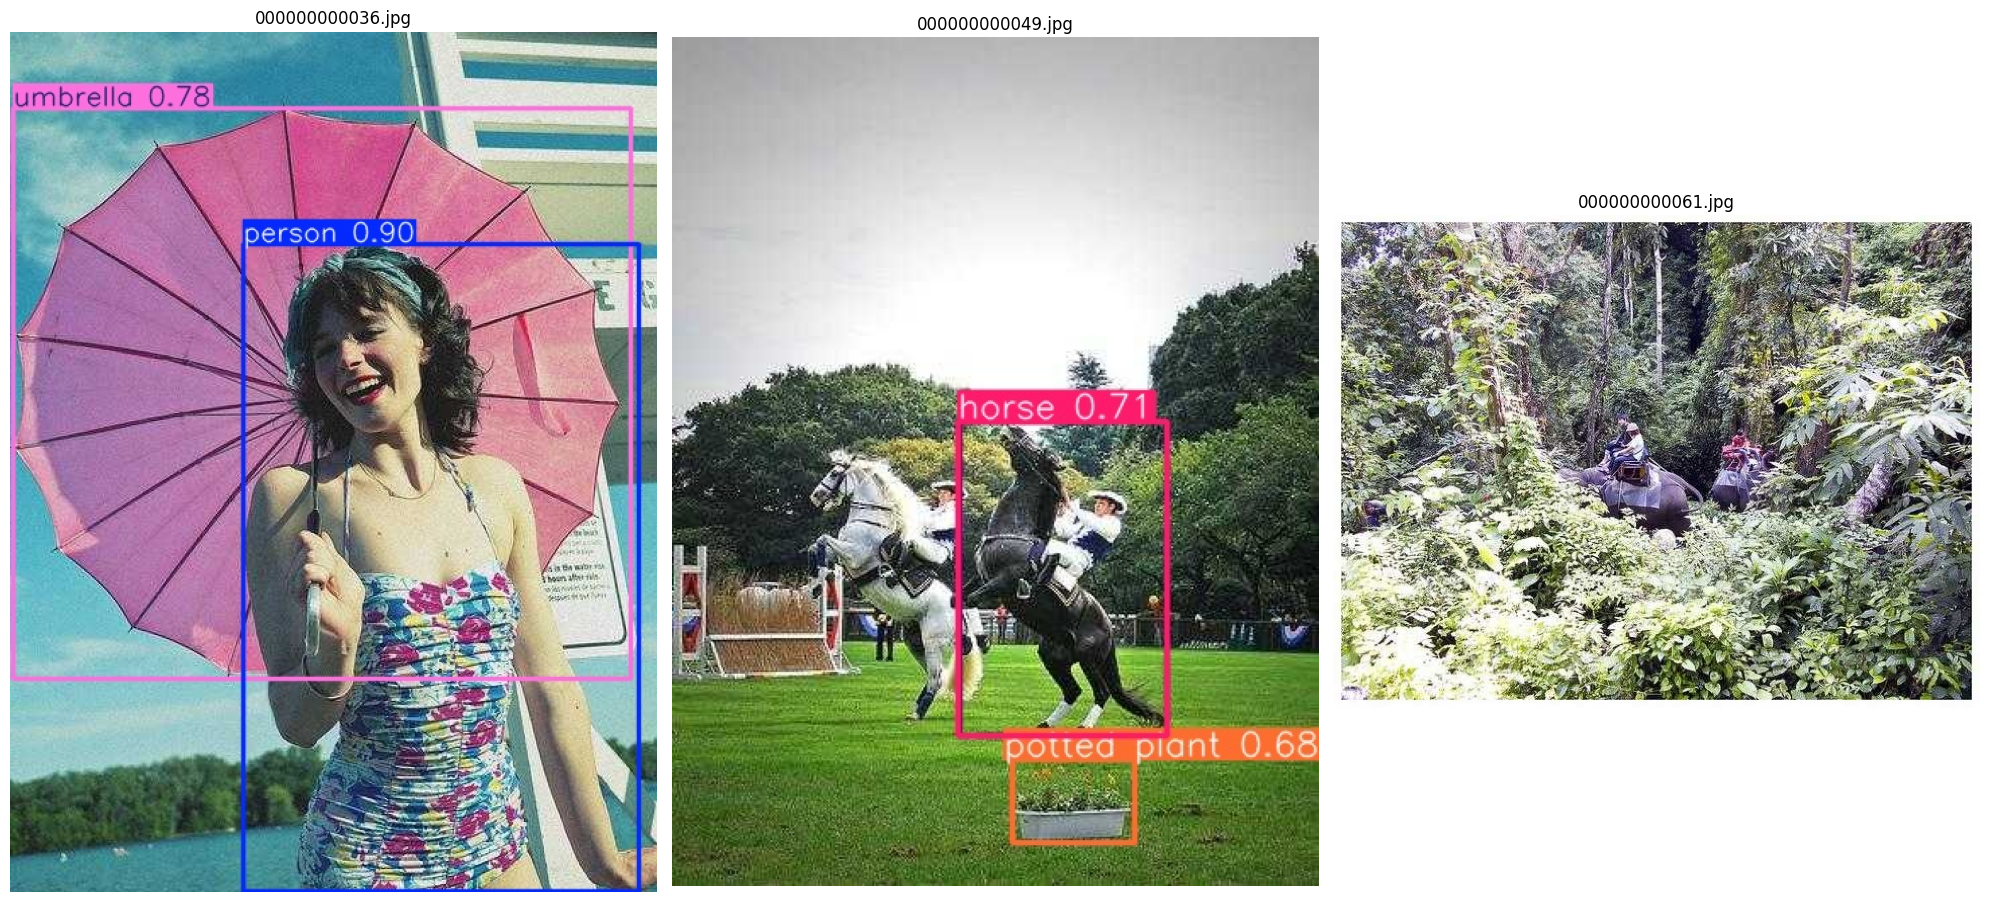

In [20]:
# Display the images with detections.
# We will load and show the images that YOLOv8 saved during the predict(save=True) step.

# Proceed only if the model was loaded and inference was attempted on some images.
if inference_model and sample_image_files:
    # Base directory where YOLOv8 saves prediction runs
    saved_results_base_dir = 'runs/detect/'
    predict_dirs = [] # To store paths of all 'predict*' directories

    # Check if the base results directory exists
    if os.path.exists(saved_results_base_dir):
        # List all directories starting with 'predict' (e.g., predict, predict2, etc.)
        predict_dirs = sorted([
            os.path.join(saved_results_base_dir, d)
            for d in os.listdir(saved_results_base_dir)
            if d.startswith('predict') and os.path.isdir(os.path.join(saved_results_base_dir, d))
        ])

    # If any 'predict*' directories were found
    if predict_dirs:
        latest_predict_dir = predict_dirs[-1] # Get the path to the most recent prediction directory
        print(f"Showing results from the latest prediction directory: {latest_predict_dir}")

        # List all image files within the latest prediction directory
        result_image_paths = [os.path.join(latest_predict_dir, f)
                              for f in os.listdir(latest_predict_dir)
                              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if result_image_paths:
            # Determine how many images to display (up to 3 or the number available)
            num_images_to_display = min(len(result_image_paths), 3)

            plt.figure(figsize=(20, 15)) # Set a larger figure size for better visibility
            for i, img_path in enumerate(result_image_paths[:num_images_to_display]):
                # Read the image using OpenCV
                img = cv2.imread(img_path)
                if img is not None:
                    # Convert image from BGR (OpenCV default) to RGB (Matplotlib default)
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # Create a subplot for each image
                    plt.subplot(1, num_images_to_display, i + 1)
                    plt.imshow(img_rgb)
                    plt.axis('off') # Hide axes for cleaner display
                    plt.title(os.path.basename(img_path)) # Show filename as title
                else:
                    print(f"Warning: Could not read image {img_path}")
            plt.tight_layout() # Adjust subplot parameters for a tight layout
            plt.show() # Display the figure with subplots
        else:
            print(f"No result images found in {latest_predict_dir}. Ensure 'model.predict(save=True)' ran correctly.")
    else:
        print(f"No prediction directory (e.g., 'runs/detect/predict*') found. Make sure 'model.predict(save=True)' was executed.")
else:
    print("Skipping display of results as either the model was not loaded or no images were processed for inference.")

The code cell above is responsible for visualizing the detection results. It works as follows:
1.  It locates the most recent prediction directory created by `inference_model.predict(save=True)` (e.g., `runs/detect/predict`, `runs/detect/predict2`, etc.).
2.  It lists the image files (JPG, PNG) within that directory.
3.  It then uses `matplotlib.pyplot` to display up to the first 3 of these images in the notebook output.
4.  OpenCV (`cv2`) is used to read the images, and they are converted from BGR (OpenCV's default color order) to RGB (Matplotlib's expected color order) for correct color display.

## 6. Conclusion

This notebook provided a step-by-step guide to performing object detection using YOLOv8. We have successfully:

1.  **Set up the environment** by installing `ultralytics`, `torch`, and `opencv-python-headless`.
2.  **Prepared the data** by downloading the **COCO8 dataset**, inspecting its structure, and creating a `custom_data.yaml` file with appropriate paths and class names for training.
3.  **Fine-tuned a pre-trained YOLOv8n model** on our custom COCO8 dataset for 25 epochs, leveraging transfer learning.
4.  **Performed inference** using the fine-tuned model on sample validation images from COCO8 and visualized the detection results, including bounding boxes and class labels.

### Potential Next Steps:

- **Experiment with different YOLOv8 models:** Try larger models like `yolov8s.pt` or `yolov8m.pt` for potentially higher accuracy, or explore specialized models if available.
- **Train for more epochs:** Increase the number of training epochs (e.g., 100, 200, or more) and monitor validation metrics to find the optimal training duration and avoid overfitting (early stopping with `patience` helps here).
- **Use a larger or different dataset:** Apply this workflow to other datasets, or expand the current dataset with more images and annotations.
- **Hyperparameter tuning:** Experiment with different learning rates, batch sizes, image sizes (`imgsz`), and data augmentation techniques to optimize model performance.
- **Evaluate model performance:** Use YOLOv8's evaluation mode (`model.val()`) to get detailed metrics like mAP (mean Average Precision) on a test set to quantitatively assess the model's accuracy.
- **Export and deploy the model:** Export the trained model to formats like ONNX or TensorRT for deployment in various applications or edge devices.
- **Explore other YOLOv8 features:** Investigate other capabilities of YOLOv8, such as segmentation, classification, or pose estimation, if your task requires them.

In [ ]:
# ------------------- 你的其他代码 (安装、数据准备、模型训练) -------------------
# ... (之前的代码，包括加载 fine_tuned_model)

# ------------------- 修改推理部分 -------------------

# 选项 1: 指定单个图片路径
# 假设你上传了一张图片到 /content/my_image.jpg
#my_image_path = '/content/my_image.jpg'

# 选项 2: 指定图片文件列表
# 假设你上传了多张图片到 /content/my_image1.jpg 和 /content/my_image2.png
my_image_list = ['/content/my_image1.jpg', '/content/my_image2.png']

# 选项 3: 指定包含图片的目录路径
# 假设你创建了一个文件夹 '/content/my_images_folder' 并上传了图片到里面
#my_images_folder_path = '/content/my_images_folder/'

# 选择你想要使用的图片源，并将路径赋给 source 变量
# 例如，使用单个图片：
#source_for_inference = my_image_path

# 或者使用图片列表：
# source_for_inference = my_image_list

# 或者使用图片目录：
# source_for_inference = my_images_folder_path

# 检查选择的图片源是否存在 (对于文件或目录)
import os
if not os.path.exists(source_for_inference):
    print(f"错误: 图片源未找到: {source_for_inference}")
    print("请确保图片已成功上传且路径正确。")
else:
    print(f"正在对图片源 '{source_for_inference}' 进行推理...")
    # 运行推理
    # conf 参数可以调整，降低阈值会检测到更多目标，但可能增加误报
    # save=True 会将结果保存到 runs/detect/predict* 目录
    results = inference_model.predict(source=source_for_inference, save=True, conf=0.5)
    print(f"推理完成。结果保存在 runs/detect/predict* 目录中。")

    # ------------------- 可视化结果 (可选，但推荐) -------------------
    # 这部分代码可以复用你笔记本中用于可视化结果的代码块
    # 它会找到最新的 predict* 目录并显示保存的图片

    # base directory where YOLOv8 saves prediction runs
    saved_results_base_dir = 'runs/detect/'
    predict_dirs = []

    if os.path.exists(saved_results_base_dir):
        predict_dirs = sorted([
            os.path.join(saved_results_base_dir, d)
            for d in os.listdir(saved_results_base_dir)
            if d.startswith('predict') and os.path.isdir(os.path.join(saved_results_base_dir, d))
        ])

    if predict_dirs:
        latest_predict_dir = predict_dirs[-1]
        print(f"\n显示来自最新预测目录的结果: {latest_predict_dir}")

        result_image_paths = [os.path.join(latest_predict_dir, f)
                              for f in os.listdir(latest_predict_dir)
                              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if result_image_paths:
            # Display up to the first 5 images
            num_images_to_display = min(len(result_image_paths), 5) # Adjust number of images to display

            plt.figure(figsize=(20, min(len(result_image_paths), 5) * 5)) # Adjust figure size
            for i, img_path in enumerate(result_image_paths[:num_images_to_display]):
                img = cv2.imread(img_path)
                if img is not None:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    plt.subplot(num_images_to_display, 1, i + 1) # Adjust subplot grid
                    plt.imshow(img_rgb)
                    plt.axis('off')
                    plt.title(os.path.basename(img_path))
                else:
                    print(f"Warning: Could not read image {img_path}")
            plt.tight_layout()
            plt.show()
        else:
            print(f"在 {latest_predict_dir} 中未找到结果图片。")
    else:
        print(f"未找到预测目录 (例如，'runs/detect/predict*')。确保 'model.predict(save=True)' 已执行。")